# Analysis: anchoring SWOW
This notebook analyses the results of incorporating anchors from SWOW into anchor acquisition stage.  

# Conc

In [1]:
import pandas as pd
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
import seaborn as sns
from copy import deepcopy
import pandas as pd

In [2]:
FREQ_UNSEEN_TERM = -1
def read_word_to_concreteness(con_path = '../data/Concreteness_ratings_Brysbaert_et_al_BRM.xlsx'):
    
    df = pd.read_excel(con_path)
    df['Conc.M'] = df['Conc.M'].apply(lambda x: float(x))
    word_to_conc = dict(zip(df['Word'], df['Conc.M']))
    return word_to_conc 
    
word_to_freq = read_word_to_concreteness() #word_to_freq: freq is the medium of concreteness score 

def add_freq_level(df, word_to_freq, cut_bins_sub, cut_bins_obj, cut_labels, sub_label_freq = 'sub_freq', obj_label_freq='obj_freq', FREQ_UNSEEN_TERM=-1,  ):
    df[sub_label_freq] = df['sub_label_sg'].apply(lambda x: word_to_freq.get(x, FREQ_UNSEEN_TERM))
    df[obj_label_freq] = df['obj_label_sg'].apply(lambda x: word_to_freq.get(eval(x)[0] if isinstance(x,str) else x[0], FREQ_UNSEEN_TERM))
     #, "VERYFREQUENT"]
    cut_bins_sub.append(df[sub_label_freq].max()) #5000,
    df['sub_freq_level'] = pd.cut(df[sub_label_freq], bins=cut_bins_sub,labels=cut_labels).values.add_categories("UNSEEN")
    df['sub_freq_level'].fillna(value='UNSEEN', inplace=True)
    
    cut_bins_obj.append(df[obj_label_freq].max()) #5000,
    df['obj_freq_level'] = pd.cut(df[obj_label_freq], bins=cut_bins_obj,labels=cut_labels).values.add_categories("UNSEEN")
    df['obj_freq_level'].fillna(value='UNSEEN', inplace=True)
    return df 




In [35]:
import seaborn as sns 
sns.set(style="white") #_theme
sns.color_palette("husl", 8)

def bar_plot_conc_abs(path, dataset):
    print("#"*10, dataset, "#"*10)
    df = pd.read_csv(path)
    cut_bins_sub = [0, 3] #[0, 10, 100]
    cut_bins_obj = [0, 3]
    cut_labels=['Abs', 'Conc']
    df = add_freq_level(df, word_to_freq, cut_bins_sub, cut_bins_obj, cut_labels, sub_label_freq = 'sub_freq', obj_label_freq='obj_freq', FREQ_UNSEEN_TERM=FREQ_UNSEEN_TERM)

    metrics_group = [
    #                 ['p10_def_sap', 'p10_def_dap'],
    #                 [ 'p1_def_sap', 'p1_def_dap', 'p1_lsp_sap', 'p1_lsp_dap'],
                    [ 'p10_def_sap', 'p10_def_dap'],# 'p10_lsp_sap', 'p10_lsp_dap'],
    #                  [ 'p5_def_sap', 'p5_def_dap', 'p5_lsp_sap', 'p5_lsp_dap'],
    #                  [ 'mrr_def_sap', 'mrr_def_dap', 'mrr_lsp_sap', 'mrr_lsp_dap'],
                    ]
    df = df.query(f"sub_freq_level in {cut_labels} and obj_freq_level in {cut_labels}")

    groupby_col = ['sub_freq_level', 'obj_freq_level']#  ['obj_freq_level'] 
    group_means =[]
    for metrics in metrics_group: 
        group_means = []
        group_index = []
        group_instances = defaultdict()
        for name, group in df.groupby(groupby_col):
            group_mean = group[metrics].mean().to_frame().round(decimals = 3)*100#'ap10_sentence', 'ap10_sentence_dap',
            group_means.append(group_mean.T)
            group_index.append("-".join(name))
            group_instances['-'.join(name)] = len(group.index)

    group_means = pd.concat(group_means)
    group_means.index = group_index 
    
    color = ['grey', 'grey', 'green', 'green']
    #fig, ax = plt.subplots(1,1,sharey=False,  figsize=(6, 4)) #figsize=(5,3))#,
    #ax = group_means.plot(kind='bar', color= color, ax=ax, width=0.6 ) #, xticks=['FREQUENT', 'MEDIUM', 'LOW', 'UNSEEN'])
#     for i, (container, hatch) in enumerate(zip(ax.containers, (" ", "x", " ", "x"))):
#         if hatch!="x": continue 
#         for patch in container.patches:
#             patch.set_hatch(hatch)
            
#     for i, bar in enumerate(ax.patches):
#         print(i, bar.get_height(), markers[i] )
#         if markers[i]=="": continue 
#         ax.annotate(markers[i],
#                        (bar.get_x() + bar.get_width() / 2,
#                         bar.get_height()*0.94), ha='center', va='center',
#                        size=10, 
#                        xytext=(0, 8),
#                        textcoords='offset points')
#     plt.legend(labels=[r'$\mathregular{DFP}$', r'$\mathregular{DFP^{+A}}$', r'$\mathregular{LSP}$', r'$\mathregular{LSP^{+A}}$'], 
#                 loc= (1.05,0.1), fontsize='x-small',ncol=1) #, ncol=len(df.columns))  prop={'size': 6}, 
    
    group_means['#instances'] = [group_instances[k] for k in group_means.index]
    display(group_means)
    
    #df['subj_anchors_num'] = df['subj_anchors_sg'].apply(lambda x: len(eval(x)))
    #display(df['subj_anchors_num'])
    #display( df.query("subj_anchors_num<5")[metrics].mean())
    
    #query = ['lipstick', 'noses', 'love', 'rains', 'linguistices', 'whole' ]
    #display(df[['sub_label', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']].head())
    #display (df.query("obj_freq_level == 'Conc' and sub_freq_level=='Abs' and p10_def_sap==0 and p10_def_dap==1").query(f"sub_label in {query}")[['sub_label', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']])
    group_means['dataset'] = dataset 
    df['dataset'] = dataset
    return df, group_means 

dataset_to_path = {"pureLM": "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_None.HYPERNYMSUITE.csv",
                   "SWOWSimilar": "../../log/bert-large-uncased/ALL/SWOWSimilar/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_SWOW_swow_score_source_None.HYPERNYMSUITE.csv",
                   "SWOWStrength": "../../log/bert-large-uncased/ALL/SWOWStrength/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_SWOW_swow_score_source_None.HYPERNYMSUITE.csv",
                   "ShareSWOWStrength": "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_ShareSWOWStrength.HYPERNYMSUITE.csv",
                   "ShareSWOWSimilar": "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_ShareSWOWSimilar.HYPERNYMSUITE.csv",
                   "AddSWOWSimilar": "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_AddSWOWSimilar.HYPERNYMSUITE.csv",
                   "AddSWOWStrength":  "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_AddSWOWStrength.HYPERNYMSUITE.csv"
                  }
dfs_mean = []
dataset_to_df = defaultdict()
# df_means = bar_plot_conc_abs(path, "pureLM")

for dataset, path in dataset_to_path.items():
    df, df_means = bar_plot_conc_abs(path, dataset)
    dfs_mean.append(df_means) 
    dataset_to_df[dataset] = df
    
dfs_mean = pd.concat(dfs_mean)


########## pureLM ##########


,p10_def_sap,p10_def_dap,#instances
Abs-Abs,37.8,45.9,98
Abs-Conc,39.7,43.1,58
Conc-Abs,21.0,24.7,186
Conc-Conc,50.3,52.1,1724


<ipython-input-35-47f36d7eb2d8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset'] = dataset


########## SWOWSimilar ##########


,p10_def_sap,p10_def_dap,#instances
Abs-Abs,38.1,46.4,97
Abs-Conc,39.7,46.6,58
Conc-Abs,21.2,24.5,184
Conc-Conc,50.3,52.4,1709


<ipython-input-35-47f36d7eb2d8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset'] = dataset


########## SWOWStrength ##########


,p10_def_sap,p10_def_dap,#instances
Abs-Abs,38.1,46.4,97
Abs-Conc,39.7,43.1,58
Conc-Abs,21.0,23.1,186
Conc-Conc,50.1,52.5,1709


########## ShareSWOWStrength ##########


<ipython-input-35-47f36d7eb2d8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset'] = dataset


,p10_def_sap,p10_def_dap,#instances
Abs-Abs,37.8,46.9,98
Abs-Conc,39.7,41.4,58
Conc-Abs,21.0,25.8,186
Conc-Conc,50.3,52.8,1724


########## ShareSWOWSimilar ##########


<ipython-input-35-47f36d7eb2d8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset'] = dataset


,p10_def_sap,p10_def_dap,#instances
Abs-Abs,37.8,45.9,98
Abs-Conc,39.7,44.8,58
Conc-Abs,21.0,25.8,186
Conc-Conc,50.3,53.1,1724


<ipython-input-35-47f36d7eb2d8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset'] = dataset


########## AddSWOWSimilar ##########


,p10_def_sap,p10_def_dap,#instances
Abs-Abs,37.8,45.9,98
Abs-Conc,39.7,44.8,58
Conc-Abs,21.0,25.8,186
Conc-Conc,50.3,53.2,1724


<ipython-input-35-47f36d7eb2d8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset'] = dataset


########## AddSWOWStrength ##########


,p10_def_sap,p10_def_dap,#instances
Abs-Abs,37.8,45.9,98
Abs-Conc,39.7,44.8,58
Conc-Abs,21.0,26.3,186
Conc-Conc,50.3,52.9,1724


<ipython-input-35-47f36d7eb2d8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset'] = dataset


In [100]:
dataset_to_df['pureLM'].columns

Index(['Unnamed: 0', 'sub_label', 'obj_label', 'relation', 'obj_in_BERT',
       'masked_sentences', 'uuid', 'sub_position', 'sub_label_sg',
       'sub_label_pl', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap',
       'anchor_lsp_sap', 'sub_label_sgpl', 'obj_mask_sentence',
       'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score',
       'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors',
       'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
       'subj_anchors_all', 'subj_anchors_combined', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'sub_sister', 'obj_label_sg', 'p1_sentence', 'p5_sentence',
       'p10_sentence', 'p1_def_sap', 'p5_def_sap', 'p10_def_sap', 'p1_lsp_sap',
       'p5_lsp_sap', 'p10_lsp_sap', 'p1_def_dap', 'p5_def_dap', 'p10_def_dap',
       'p1_lsp_dap', 'p5_lsp_dap', 'p10_lsp_dap', 'mrr_sentence',
      

In [5]:
# dataset_to_df.keys()
from scipy import stats 
min_pvalue=0.05
group = ['']
for dataset in dataset_to_df.keys():
    if dataset in 'pureLM': continue 
    df1 = dataset_to_df['pureLM']
    df2 = dataset_to_df[dataset]
    #statistic, pvalue = stats.ttest_rel(df1['p10_def_dap'], df2['p10_def_dap'])
    df3 = df1.merge(df2, on = ['sub_label', 'obj_label'])
#     statistic, pvalue = stats.ttest_rel(df3['mrr_def_dap_x'], df3['mrr_def_dap_y'])
    statistic, pvalue = stats.ttest_rel(df3['p10_def_dap_x'], df3['p10_def_dap_y'])
    reject_np = True if pvalue < min_pvalue else False 
    print("overall:", dataset, statistic, pvalue, reject_np)
#     for name, group in df1.groupby(['sub_freq_level', 'obj_freq_level']):
#         statistic, pvalue = stats.ttest_rel ( group['p10_def_sap'], df2.query(f"sub_freq_level=='{name[0]}' and obj_freq_level=='{name[1]}'")['p10_def_dap'])
#         reject_np = True if pvalue < min_pvalue else False 
#         print(name, dataset, statistic, pvalue, reject_np)
    print("\n")
#     for name, group in df1.groupby(['obj_freq_level']):
#         statistic, pvalue = stats.ttest_rel ( group['p10_def_dap'], df2.query(f"obj_freq_level=='{name}'")['p10_def_dap'])
#         reject_np = True if pvalue < min_pvalue else False 
#         print(name, dataset, statistic, pvalue, reject_np)


overall: SWOWSimilar -0.6080700553253817 0.5432084691436202 False


overall: SWOWStrength -0.4453122340260653 0.656141168989594 False


overall: ShareSWOWStrength -1.2676866385795769 0.2050528004460973 False


overall: ShareSWOWSimilar -1.9715843794385501 0.048790372919413724 True


overall: AddSWOWSimilar -2.4323826034897187 0.015084296181910472 True


overall: AddSWOWStrenth -2.110352142953258 0.03494800601907855 True




## Conc Visualization

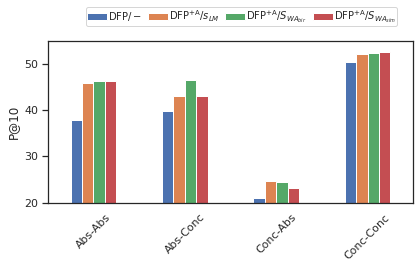

In [9]:
import matplotlib.ticker as ticker
from matplotlib import rcParams
rcParams['font.family'] = 'times'
rcParams['font.size'] = 16
import math
import seaborn as sns 
sns.set(style="white") #_theme
sns.color_palette("husl", 8)

dfs_mean['concreteness'] = dfs_mean.index
df1 = dfs_mean.query(f"dataset == 'pureLM'")[['concreteness','p10_def_sap', 'dataset']].rename(columns={"p10_def_sap": "p10"})
df1['model'] = ''
df2 = dfs_mean.query(f"dataset == 'pureLM'")[['concreteness','p10_def_dap', 'dataset']].rename(columns={"p10_def_dap": "p10"})
df2['model'] = 'LMAnchor'
# df3 = dfs_mean.query(f"dataset == 'AddSWOWSimilar'")[['concreteness','p10_def_dap', 'dataset']].rename(columns={"p10_def_dap": "p10"})
df3 = dfs_mean.query(f"dataset == 'SWOWStrength'")[['concreteness','p10_def_dap', 'dataset']].rename(columns={"p10_def_dap": "p10"})
df3['model'] = 'LMSWOWAnchorStrength'

df4 = dfs_mean.query(f"dataset == 'SWOWSimilar'")[['concreteness','p10_def_dap', 'dataset']].rename(columns={"p10_def_dap": "p10"})
df4['model'] = 'LMSWOWAnchorSimilar'
df_res = pd.concat([df1, df2, df3, df4], axis=0)
ax = pd.pivot(df_res.sort_values('model', ascending=False), index='concreteness', values='p10', columns='model').plot(kind = 'bar', ylim=(20, 55), figsize=(6,4))
# dfs_mean.query(f"dataset in == pureLM")[['concreteness','p10_def_dap']],
# dfs_mean.query(f"dataset in == AddSWOWSimilar")[['concreteness','p10_def_dap']]
# ax = pd.pivot(dfs_mean.query(f"dataset in {query_dataset}"), index='concreteness', values=['p10_def_sap','p10_def_dap'], columns='dataset' ).plot(kind="bar", ylim=(20, 55))
ax.set_ylabel('P@10')
ax.set(xlabel=None)
ax.set_xticklabels(['Abs-Abs', 'Abs-Conc', 'Conc-Abs', 'Conc-Conc'] , rotation = 45)
# plt.legend(loc=(1.01,0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='major',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=True,
            left=True #if dataset=='DIAG' else False
        ) # labels

# labels=[r'$\mathregular{DFP}/-$', r'$\mathregular{DFP^{+A}}/s_{LM}$', r'$\mathregular{DFP^{+A}}/s_{LM}+ S_{WA_{sim}}$']
labels=[r'$\mathregular{DFP}/-$', r'$\mathregular{DFP^{+A}}/s_{LM}$', r'$\mathregular{DFP^{+A}}/S_{WA_{bir}}$', r'$\mathregular{DFP^{+A}}/S_{WA_{sim}}$']
plt.legend(labels, ncol=len(labels), loc= 'center',bbox_to_anchor=(0.53, 1.15),
           fontsize='small', borderaxespad=-0.1,
           labelspacing=0.5, columnspacing=0.6,
           handletextpad=0.1,
           borderpad=0.1,
          ) 

# markers = ['', '', '', '', '', '', '', '', '', '', '', u"$\u2021$"]
# for i, bar in enumerate(ax.patches):
#     print(i, bar.get_height(), markers[i] )
#     if markers[i]=="": continue 
#     ax.annotate(markers[i],
#                    (bar.get_x() + bar.get_width() / 2,
#                     bar.get_height()*0.97), ha='center', va='center',
#                    size=10, 
#                    xytext=(0, 8),
#                    textcoords='offset points')

plt.tight_layout()
# plt.savefig('../log/barplot_with_swow_sim_anchors_concreteness.pdf')

In [20]:
dataset_to_df['ShareSWOWSimilar'].query("sub_freq_level == 'Abs' and obj_freq_level == 'Abs' and p10_def_sap==0 and p5_def_dap==1")[['sub_label', 'obj_label', 'subj_anchors_sg', 'obj_mask_def_sap', 'obj_mask_def_dap']]#.sample(10)

,sub_label,obj_label,subj_anchors_sg,obj_mask_def_sap,obj_mask_def_dap
1098,love,['feeling'],"['hate', 'loss', 'yes', 'sex', 'lust']","['relationship', 'mistake', 'lie', 'emotion', 'marriage', 'affection', 'passion', 'desire', 'friendship', 'gift']","['relationship', 'loss', 'emotion', 'feeling', 'desire', 'passion', 'hate', 'lie', 'mistake', 'affection']"
1138,calculations,['procedure'],"['mathematical', 'equation']","['computation', 'measurement', 'analysis', 'statement', 'operation', 'formula', 'proof', 'action', 'process', 'decision']","['computation', 'formula', 'process', 'measurement', 'procedure', 'function', 'analysis', 'equation', 'statement', 'test']"
1183,wrath,['emotion'],"['anger', 'rage', 'hatred']","['curse', 'vengeance', 'demon', 'fury', 'rage', 'punishment', 'hate', 'warning', 'blessing', 'fear']","['anger', 'emotion', 'rage', 'curse', 'reaction', 'hate', 'hatred', 'feeling', 'fury', 'passion']"
1234,optimism,['feeling'],"['positive', 'hope']","['hope', 'mood', 'lie', 'mistake', 'joy', 'belief', 'happiness', 'failure', 'personality', 'certainty']","['belief', 'hope', 'happiness', 'positive', 'feeling', 'emotion', 'mood', 'statement', 'outlook', 'possibility']"
1336,bargains,['agreement'],"['financial', 'yes', 'contract', 'promise', 'deal']","['deal', 'currency', 'contract', 'coin', 'exchange', 'trade', 'transaction', 'payment', 'money', 'price']","['contract', 'transaction', 'deal', 'agreement', 'exchange', 'payment', 'trade', 'promise', 'negotiation', 'price']"
1365,resentments,['emotion'],"['personal', 'yes', 'anger', 'political', 'maybe']","['anger', 'betrayal', 'hatred', 'bitterness', 'weakness', 'frustration', 'hate', 'argument', 'conflict', 'debt']","['anger', 'emotion', 'conflict', 'reaction', 'yes', 'bitterness', 'feeling', 'lie', 'frustration', 'hatred']"
1419,neurologies,['science'],"['neuroscience', 'psychology', 'genetics', 'biological', 'theory']","['neuroscience', 'psychiatry', 'medicine', 'pathology', 'psychiatrist', 'diagnosis', 'psychology', 'disease', 'surgery', 'study']","['neuroscience', 'study', 'science', 'medicine', 'psychology', 'diagnosis', 'pathology', 'psychiatry', 'theory', 'specialty']"
1448,remorse,['feeling'],"['guilt', 'regret']","['sin', 'mistake', 'pain', 'guilt', 'shame', 'punishment', 'lie', 'emotion', 'regret', 'confession']","['emotion', 'guilt', 'regret', 'feeling', 'sin', 'pain', 'sadness', 'depression', 'sorrow', 'crime']"
1452,jealousies,['feeling'],"['yes', 'envy', 'sexual', 'anger', 'maybe']","['anger', 'emotion', 'rivalry', 'betrayal', 'reaction', 'hatred', 'conflict', 'relationship', 'obsession', 'rage']","['emotion', 'anger', 'feeling', 'reaction', 'lie', 'conflict', 'relationship', 'yes', 'desire', 'love']"


In [36]:
dataset_to_df['AddSWOWStrength'].query("sub_freq_level == 'Abs' and obj_freq_level == 'Abs' and p10_lsp_sap==0 and p10_lsp_dap==1")[['sub_label', 'obj_label', 'subj_anchors_sg', 'obj_mask_def_sap', 'obj_mask_lsp_sap', 'obj_mask_lsp_dap']]#.sample(10)

,sub_label,obj_label,subj_anchors_sg,obj_mask_def_sap,obj_mask_lsp_sap,obj_mask_lsp_dap
961,secret,['information'],"['private', 'personal', 'quiet', 'unknown', 'actually']","['information', 'lie', 'communication', 'mystery', 'code', 'secrecy', 'document', 'message', 'promise', 'knowledge']","['thing', 'magazine', 'secret', 'game', 'story', 'book', 'place', 'word', 'website', 'site']","['thing', 'term', 'secret', 'information', 'private', 'word', 'yes', 'category', 'place', 'concept']"
1183,wrath,['emotion'],"['human', 'self', 'john', 'beth', 'anger']","['curse', 'vengeance', 'demon', 'fury', 'rage', 'punishment', 'hate', 'warning', 'blessing', 'fear']","['demon', 'story', 'thing', 'god', 'yes', 'yeah', 'tale', 'creature', 'hell', 'evil']","['demon', 'emotion', 'thing', 'yes', 'feeling', 'yeah', 'male', 'story', 'god', 'female']"
1234,optimism,['feeling'],"['hope', 'maybe', 'yes', 'good', 'religious']","['hope', 'mood', 'lie', 'mistake', 'joy', 'belief', 'happiness', 'failure', 'personality', 'certainty']","['hope', 'thing', 'emotion', 'quality', 'concept', 'belief', 'value', 'idea', 'yes', 'thought']","['thing', 'emotion', 'yes', 'concept', 'quality', 'word', 'value', 'hope', 'belief', 'feeling']"
1827,pleasures,['emotion'],"['sexual', 'pain', 'yes', 'physical', 'sensual']","['pain', 'sin', 'curse', 'activity', 'enjoyment', 'luxury', 'joy', 'crime', 'relief', 'experience']","['thing', 'passion', 'problem', 'concern', 'quality', 'feeling', 'needs', 'good', 'matter', 'desire']","['thing', 'sensation', 'health', 'concept', 'feeling', 'yes', 'activity', 'emotion', 'attraction', 'term']"
1868,reasons,['fact'],"['personal', 'purpose', 'political', 'fact', 'yes']","['explanation', 'belief', 'argument', 'justification', 'action', 'statement', 'cause', 'rule', 'proof', 'lie']","['thing', 'consideration', 'question', 'yes', 'factor', 'information', 'motive', 'circumstance', 'matter', 'issue']","['thing', 'yes', 'consideration', 'matter', 'information', 'question', 'fact', 'issue', 'factor', 'circumstance']"


In [19]:
# dataset_to_df['SWOWStrength'][['subj_anchors', 'subj_anchors_swow', 'def_dap_with_subj_anchor']]

,subj_anchors,subj_anchors_swow,def_dap_with_subj_anchor
0,"['bass', 'carp', 'shrimp', 'perch', 'alligator', 'trout', 'rabbit', 'channel', 'cod', 'turtles']","['whiskers', 'catsups']","['a catfish or a whisker is a [MASK].', 'a catfish or a catsup is a [MASK].', 'a catfish or a whisker is a type of [MASK].', 'a catfish or a catsup is a type of [MASK].', 'a catfish or a whisker is a kind of [MASK].', 'a catfish or a catsup is a kind of [MASK].']"
1,"['lime', 'orange', 'apple', 'yes', 'cherry', 'water', 'pepper', 'sugar', 'yellow', 'chocolate']","['limes', 'sour', 'citruses', 'yellow', 'rinds', 'lemonades', 'tarts', 'bitter', 'juices', 'squeeze', 'orange', 'peel', 'puckers', 'tequila', 'acids', 'sprites', 'teas', 'melons', 'waters', 'limo', 'squash']","['a lemon or a lime is a [MASK].', 'a lemon or a sour is a [MASK].', 'a lemon or a citrus is a [MASK].', 'a lemon or a yellow is a [MASK].', 'a lemon or a rinds is a [MASK].', 'a lemon or a lime is a type of [MASK].', 'a lemon or a sour is a type of [MASK].', 'a lemon or a citrus is a type of [MASK].', 'a lemon or a yellow is a type of [MASK].', 'a lemon or a rinds is a type of [MASK].', 'a lemon or a lime is a kind of [MASK].', 'a lemon or a sour is a kind of [MASK].', 'a lemon or a citrus is a kind of [MASK].', 'a lemon or a yellow is a kind of [MASK].', 'a lemon or a rinds is a kind of [MASK].']"
2,"['snakes', 'birds', 'fish', 'lizards', 'frogs', 'dragons', 'sharks', 'monkeys', 'bears', 'deer']","['tortoises', 'shells', 'slow', 'ninja', 'reptile', 'seas', 'necks', 'amphibian', 'awkward', 'shields', 'rabbits', 'back', 'speedy', 'ponds', 'scales']","['a turtle or a tortoise is a [MASK].', 'a turtle or a shell is a [MASK].', 'a turtle or a slow is a [MASK].', 'a turtle or a ninja is a [MASK].', 'a turtle or a reptile is a [MASK].', 'a turtle or a tortoise is a type of [MASK].', 'a turtle or a shell is a type of [MASK].', 'a turtle or a slow is a type of [MASK].', 'a turtle or a ninja is a type of [MASK].', 'a turtle or a reptile is a type of [MASK].', 'a turtle or a tortoise is a kind of [MASK].', 'a turtle or a shell is a kind of [MASK].', 'a turtle or a slow is a kind of [MASK].', 'a turtle or a ninja is a kind of [MASK].', 'a turtle or a reptile is a kind of [MASK].']"
3,"['boxes', 'yes', 'shoes', 'cases', 'obviously', 'yeah', 'clothes', 'things', 'maybe', 'packages']","['tote', 'satchel', 'sack', 'purses', 'plastics', 'shopping', 'carry', 'pouches', 'papers', 'pack', 'backpacks', 'brown', 'carriers', 'trashes', 'canvas', 'beg', 'shoulders', 'parcels', 'lunches', 'bookbag', 'bundle', 'capture', 'travels', 'cases', 'rag', 'lag', 'pockets', 'wallets', 'snag', 'puss', 'nag', 'stuffs', 'baskets', 'shoes', 'sweets']","['a bag or a tote is a [MASK].', 'a bag or a satchel is a [MASK].', 'a bag or a sack is a [MASK].', 'a bag or a purse is a [MASK].', 'a bag or a plastic is a [MASK].', 'a bag or a tote is a type of [MASK].', 'a bag or a satchel is a type of [MASK].', 'a bag or a sack is a type of [MASK].', 'a bag or a purse is a type of [MASK].', 'a bag or a plastic is a type of [MASK].', 'a bag or a tote is a kind of [MASK].', 'a bag or a satchel is a kind of [MASK].', 'a bag or a sack is a kind of [MASK].', 'a bag or a purse is a kind of [MASK].', 'a bag or a plastic is a kind of [MASK].']"
4,"['foxes', 'deer', 'squirrels', 'mice', 'rodents', 'rats', 'dogs', 'fox', 'wolves', 'snakes']","['bunny', 'roger', 'carrots', 'white', 'rodent', 'jack', 'lettuce', 'rabbi', 'magics', 'tails', 'pet', 'rascal', 'rabbits', 'speedy', 'bounces', 'turtles', 'cats', 'paws', 'tortoises', 'shoot', 'small']","['a rabbit or a bunny is a [MASK].', 'a rabbit or a roger is a [MASK].', 'a rabbit or a carrot is a [MASK].', 'a rabbit or a white is a [MASK].', 'a rabbit or a rodent is a [MASK].', 'a rabbit or a bunny is a type of [MASK].', 'a rabbit or a roger is a type of [MASK].', 'a rabbit or a carrot is a type of [MASK].', 'a rabbit or a white is a type of [MASK].', 'a rabbit or a rodent is a type of [MASK].'

In [55]:
dfq = dataset_to_df['SWOWStrength'].query("sub_freq_level == 'Abs' and obj_freq_level =='Abs' and p10_def_sap==0 and p10_def_dap==0 ")[['sub_label_sg', 'obj_label', 
                                                                                            'p10_def_sap', 'p10_def_dap', 'subj_anchors',        
                                                                                            'subj_anchors_swow_sg', 'obj_mask_def_sap', 'obj_mask_def_dap']]
print(len(dfq.index) , len(dataset_to_df['SWOWStrength'].query("sub_freq_level == 'Abs' and obj_freq_level =='Abs'").index))
print(Counter(dfq['obj_label'].to_list()).most_common())
display(dfq.head(20))

48 97
[("['feeling']", 5), ("['emotion']", 4), ("['care']", 2), ("['discipline']", 2), ("['trait']", 2), ("['science']", 2), ("['event']", 2), ("['action']", 2), ("['change']", 2), ("['sensation']", 1), ("['rate']", 1), ("['procedure']", 1), ("['idea']", 1), ("['deity']", 1), ("['improvement']", 1), ("['concept']", 1), ("['decree']", 1), ("['information']", 1), ("['agreement']", 1), ("['inference']", 1), ("['calculation']", 1), ("['statement']", 1), ("['illusion']", 1), ("['democracy']", 1), ("['honesty']", 1), ("['freedom']", 1), ("['order']", 1), ("['satisfaction']", 1), ("['degree']", 1), ("['fact']", 1), ("['comfort']", 1), ("['ideology']", 1), ("['success']", 1), ("['belief']", 1)]


,sub_label_sg,obj_label,p10_def_sap,p10_def_dap,subj_anchors,subj_anchors_swow_sg,obj_mask_def_sap,obj_mask_def_dap
967,sweetness,['sensation'],0,0,"['flavors', 'yes', 'spices', 'sugar', 'scents', 'bitter', 'honey', 'herbs', 'sweet', 'wines']","['candy', 'kindness', 'niceness', 'syrup']","['food', 'taste', 'dessert', 'weakness', 'sugar', 'sweet', 'candy', 'flavor', 'lie', 'gift']","['candy', 'syrup', 'sugar', 'flavor', 'fruit', 'drink', 'quality', 'food', 'substance', 'kindness']"
985,therapy,['care'],0,0,"['treatments', 'drugs', 'medications', 'pharmaceuticals', 'medicines', 'vaccines', 'herbal', 'research', 'medicine', 'techniques']","['psychologist', 'physical', 'session', 'psychiatrist', 'treatment']","['treatment', 'intervention', 'education', 'medicine', 'process', 'cure', 'research', 'communication', 'activity', 'work']","['psychologist', 'treatment', 'therapist', 'process', 'psychiatrist', 'test', 'counseling', 'person', 'professional', 'exercise']"
997,thrill,['emotion'],0,0,"['sexual', 'excitement', 'yes', 'real', 'food', 'erotic', 'maybe', 'fun', 'surprises', 'drugs']","['adrenaline', 'adventure', 'chill', 'suspenses']","['entertainment', 'pleasure', 'excitement', 'rush', 'game', 'activity', 'event', 'vacation', 'fun', 'challenge']","['feeling', 'sensation', 'excitement', 'energy', 'pleasure', 'reaction', 'entertainment', 'adventure', 'activity', 'adrenaline']"
1000,velocity,['rate'],0,0,"['speeds', 'absolute', 'knots', 'speed', 'pressures', 'acceleration', 'mph', 'miles', 'constant', 'tons']","['speed', 'acceleration', 'physics', 'vector', 'terminal']","['acceleration', 'quantity', 'displacement', 'number', 'force', 'function', 'energy', 'pressure', 'constant', 'vector']","['quantity', 'acceleration', 'force', 'vector', 'function', 'motion', 'energy', 'number', 'variable', 'movement']"
1022,arithmetic,['discipline'],0,0,"['statistics', 'algebra', 'numbers', 'geometry', 'logic', 'composition', 'probability', 'rational', 'mathematics', 'word']","['math', 'addition', 'reading', 'mathematics', 'plus']","['number', 'algebra', 'computation', 'function', 'mathematics', 'formula', 'math', 'sequence', 'set', 'calculation']","['number', 'computation', 'calculation', 'multiplication', 'function', 'math', 'operation', 'mathematics', 'formula', 'unit']"
1070,apathy,['feeling'],0,0,"['yes', 'indifference', 'maybe', 'hatred', 'fear', 'anger', 'political', 'greed', 'self', 'ignorance']","['uncaring', 'lazinesses', 'lethargy', 'uninterested', 'blah']","['lie', 'prejudice', 'weakness', 'denial', 'indifference', 'sin', 'ignorance', 'fear', 'anger', 'bias']","['depression', 'negative', 'disease', 'attitude', 'anger', 'prejudice', 'anxiety', 'illness', 'indifference', 'disorder']"
1078,terror,['emotion'],0,0,"['supernatural', 'yes', 'nightmares', 'natural', 'human', 'dreams', 'real', 'monsters', 'ghosts', 'horrors']","['terrorist', 'scared', 'reign', 'nightmares', 'phobia']","['horror', 'fear', 'monster', 'nightmare', 'panic', 'fright', 'animal', 'death', 'anxiety', 'illness']","['fear', 'terrorist', 'terrorism', 'horror', 'anxiety', 'nightmare', 'threat', 'crime', 'panic', 'person']"
1100,perseverance,['trait'],0,0,"['courage', 'determination', 'self', 'job', 'dedication', 'bravery', 'persistence', 'maybe', 'patience', 'actually']","['persistence', 'stamina', 'resilience', 'willpower', 'stoic']","['failure', 'reward', 'virtue', 'motivation', 'persistence', 'sacrifice', 'resistance', 'weakness', 'success', 'mistake']","['virtue', 'reward', 'motivation', 'persistence', 'resistance', 'endurance', 'strength', 'quality', 'success', 'commitment']"
1128,calculation,['procedure'],0,0,"['mathematical', 'actually', 'financial', 'yes', 'scientific', 'experiments', 'maybe', 'equations', 'simulations', 'measurements']","['calculator', 'math', 'mathematics', 'add', 'addition']","['computation', 'measurement', 'analysis', 'statement', 'operation', 'formula', 'proof', 'action', 'process', 'decision']","['computation', 'computer', 'operation', 'machin

TypeError: tuple expected at most 1 argument, got 2

In [54]:

dfq = dataset_to_df['AddSWOWSimilar'].query("sub_freq_level == 'Abs' and obj_freq_level =='Abs' and p10_def_sap==0 and p10_def_dap==0 ")[['sub_label_sg', 'obj_label', 
                                                                                            'p10_def_sap', 'p10_def_dap',
                                                                                            'subj_anchors_sg', 'obj_mask_def_sap', 'obj_mask_def_dap']]



# for sub_label in dfq['sub_label_sg'].to_list():
print(len(dfq.index))
print(Counter(dfq['obj_label'].to_list()).most_common())
display(dfq.head(20))

id_set2 = set(dfq['sub_label_sg'])
print(len(id_set1.intersection(id_set2)), id_set1.intersection(id_set2))

47
[("['feeling']", 6), ("['emotion']", 3), ("['discipline']", 3), ("['care']", 2), ("['trait']", 2), ("['event']", 2), ("['action']", 2), ("['rate']", 1), ("['doctrine']", 1), ("['procedure']", 1), ("['idea']", 1), ("['deity']", 1), ("['improvement']", 1), ("['concept']", 1), ("['decree']", 1), ("['saying']", 1), ("['information']", 1), ("['treatment']", 1), ("['inference']", 1), ("['change']", 1), ("['statement']", 1), ("['illusion']", 1), ("['democracy']", 1), ("['honesty']", 1), ("['freedom']", 1), ("['sadness']", 1), ("['order']", 1), ("['satisfaction']", 1), ("['degree']", 1), ("['fact']", 1), ("['comfort']", 1), ("['ideology']", 1), ("['success']", 1), ("['belief']", 1)]


,sub_label_sg,obj_label,p10_def_sap,p10_def_dap,subj_anchors_sg,obj_mask_def_sap,obj_mask_def_dap
992,therapy,['care'],0,0,"['treatment', 'drug', 'medication', 'pharmaceutical', 'medicine']","['treatment', 'intervention', 'education', 'medicine', 'process', 'cure', 'research', 'communication', 'activity', 'work']","['treatment', 'medicine', 'drug', 'medication', 'process', 'cure', 'diagnosis', 'therapeutic', 'substance', 'procedure']"
1004,thrill,['emotion'],0,0,"['sexual', 'excitement', 'yes', 'real', 'food']","['entertainment', 'pleasure', 'excitement', 'rush', 'game', 'activity', 'event', 'vacation', 'fun', 'challenge']","['pleasure', 'sensation', 'excitement', 'feeling', 'entertainment', 'activity', 'experience', 'reward', 'event', 'food']"
1007,velocity,['rate'],0,0,"['speed', 'absolute', 'knot', 'pressure', 'acceleration']","['acceleration', 'quantity', 'displacement', 'number', 'force', 'function', 'energy', 'pressure', 'constant', 'vector']","['knot', 'quantity', 'acceleration', 'force', 'energy', 'constant', 'pressure', 'number', 'measure', 'variable']"
1030,arithmetic,['discipline'],0,0,"['algebra', 'math', 'mathematics', 'multiplication', 'number']","['number', 'algebra', 'computation', 'function', 'mathematics', 'formula', 'math', 'sequence', 'set', 'calculation']","['number', 'computation', 'function', 'mathematics', 'calculation', 'algebra', 'math', 'unit', 'multiplication', 'operation']"
1078,apathy,['feeling'],0,0,"['ignorance', 'pity', 'hatred', 'racism', 'resentment']","['lie', 'prejudice', 'weakness', 'denial', 'indifference', 'sin', 'ignorance', 'fear', 'anger', 'bias']","['prejudice', 'anger', 'sin', 'lie', 'ignorance', 'discrimination', 'crime', 'resentment', 'hatred', 'racism']"
1084,aesthetic,['doctrine'],0,0,"['artistic', 'political', 'historical', 'spiritual', 'literary']","['art', 'design', 'value', 'product', 'artwork', 'work', 'architecture', 'object', 'expression', 'process']","['art', 'work', 'artwork', 'object', 'design', 'concept', 'painting', 'expression', 'value', 'movement']"
1087,terror,['emotion'],0,0,"['supernatural', 'yes', 'nightmares', 'natural', 'human']","['horror', 'fear', 'monster', 'nightmare', 'panic', 'fright', 'animal', 'death', 'anxiety', 'illness']","['monster', 'fear', 'horror', 'creature', 'animal', 'nightmare', 'human', 'demon', 'person', 'beast']"
1109,perseverance,['trait'],0,0,"['persistence', 'determination', 'endurance', 'dedication', 'effort']","['failure', 'reward', 'virtue', 'motivation', 'persistence', 'sacrifice', 'resistance', 'weakness', 'success', 'mistake']","['reward', 'virtue', 'success', 'persistence', 'motivation', 'commitment', 'action', 'decision', 'dedication', 'effort']"
1138,calculation,['procedure'],0,0,"['mathematical', 'actually', 'financial', 'yes', 'scientific']","['computation', 'measurement', 'analysis', 'statement', 'operation', 'formula', 'proof', 'action', 'process', 'decision']","['computation', 'answer', 'measurement', 'statement', 'formula', 'process', 'transaction', 'analysis', 'decision', 'test']"
1141,logic,['discipline'],0,0,"['mathematics', 'language', 'algorithm', 'ethics', 'database']","['language', 'grammar', 'mathematics', 'proof', 'sentence', 'statement', 'system', 'computation', 'formula', 'rule']","['database', 'language', 'philosophy', 'mathematics', 'system', 'ethics', 'grammar', 'computer', 'law', 'science']"


39 {'recovery', 'love', 'apathy', 'resignation', 'terror', 'religion', 'zeal', 'pride', 'quality', 'adventure', 'knowledge', 'perseverance', 'muse', 'peace', 'patience', 'parameter', 'theory', 'therapy', 'agreement', 'trouble', 'thrill', 'solution', 'value', 'respect', 'independence', 'integrity', 'information', 'reason', 'relief', 'analogy', 'arithmetic', 'propaganda', 'calculation', 'kindness', 'logic', 'age', 'ban', 'velocity', 'action'}


# Consistency

## Pair

In [12]:
from scipy import stats 
min_pvalue=0.05


dataset_to_path = {
"AddSWOWSimilar": "../../log/bert-large-uncased/hypernymsuite/ALL/AddSWOWSimilar/consistency_rw//IsA.lsp_dap.csv",
"AddSWOWStrength": "../../log/bert-large-uncased/hypernymsuite/ALL/AddSWOWStrength/consistency_rw//IsA.lsp_dap.csv",
"pureLM": "../../log/bert-large-uncased/hypernymsuite/ALL/LM/consistency_rw//IsA.lsp_dap.csv",
"ShareSWOWStrength": "../../log/bert-large-uncased/hypernymsuite/ALL/ShareSWOWStrength/consistency_rw//IsA.lsp_dap.csv",
"ShareSWOWSimilar": "../../log/bert-large-uncased/hypernymsuite/ALL/ShareSWOWSimilar/consistency_rw//IsA.lsp_dap.csv"}

dataset_to_dfpair = {}
for dataset, path in dataset_to_path.items():
    df = pd.read_csv(path)
    dataset_to_dfpair[dataset] = df
    #display(df.columns)
    
for dataset in dataset_to_dfpair.keys():
    if dataset in 'pureLM': continue 
    df1 = dataset_to_dfpair['pureLM']
    df2 = dataset_to_dfpair[dataset]
    #print(df1.columns)
    #print(df2.columns)
    #statistic, pvalue = stats.ttest_rel(df1['p10_lsp_dap'], df2['p10_lsp_dap'])
    df3 = df1.merge(df2, on = ['sub_label_singular', 'obj_label_singular'])
#     statistic, pvalue = stats.ttest_rel(df3['mrr_lsp_sap'], df3['mrr_lsp_sap'])
    statistic, pvalue = stats.ttest_rel(df3['p10_sgpl_x'], df3['p10_sgpl_y'])
    reject_np = True if pvalue < min_pvalue else False 
    print("overall:", dataset, statistic, pvalue, reject_np)
    

overall: AddSWOWSimilar -4.1037453895686085 4.221001833747612e-05 True
overall: AddSWOWStrength -0.674112028369399 0.5003145350394183 False
overall: ShareSWOWStrength 0.4788249990866493 0.6321131476917474 False
overall: ShareSWOWSimilar -1.7016097493547828 0.08897706675533036 False


In [15]:
df = pd.read_csv("../../log/bert-large-uncased/hypernymsuite/ALL/LM/consistency_rw_group//IsA.def_dap.csv")
df.columns

Index(['Unnamed: 0', 'sub_label_singular', 'obj_label_singular',
       'sub_label_plural', 'obj_label_plural', 'uuid', 'relation',
       'mask_sentences_singular_1', 'mask_sentences_singular_2',
       'mask_sentences_singular_3', 'mask_sentences_plural_1',
       'mask_sentences_plural_2', 'mask_sentences_plural_3',
       'obj_mask_sentence_sg_1', 'obj_mask_sentence_sg_1_score',
       'obj_mask_sentence_pl_1', 'obj_mask_sentence_1_pl_score',
       'obj_mask_sentence_sg_2', 'obj_mask_sentence_sg_2_score',
       'obj_mask_sentence_pl_2', 'obj_mask_sentence_2_pl_score',
       'obj_mask_sentence_sg_3', 'obj_mask_sentence_sg_3_score',
       'obj_mask_sentence_pl_3', 'obj_mask_sentence_3_pl_score', 'p1_sg_1',
       'p1_pl_1', 'p1_sg_2', 'p1_pl_2', 'p1_sg_3', 'p1_pl_3', 'p1_sg', 'p1_pl',
       'p1_sgpl'],
      dtype='object')

## Group

In [16]:
from scipy import stats 
min_pvalue=0.05

dataset_to_path = {
    "NoAnchor": "../../log/bert-large-uncased/hypernymsuite/ALL/LM/consistency_rw_group//IsA.def_sap.csv",
    "pureLM": "../../log/bert-large-uncased/hypernymsuite/ALL/LM/consistency_rw_group//IsA.def_dap.csv",
    "ShareSWOWSimilar": "../../log/bert-large-uncased/hypernymsuite/ALL/ShareSWOWSimilar/consistency_rw_group//IsA.def_dap.csv",
    "ShareSWOWStrength": "../../log/bert-large-uncased/hypernymsuite/ALL/ShareSWOWStrength/consistency_rw_group//IsA.def_dap.csv",
    "AddSWOWSimilar": "../../log/bert-large-uncased/hypernymsuite/ALL/AddSWOWSimilar/consistency_rw_group//IsA.def_dap.csv",
    "AddSWOWStrength": "../../log/bert-large-uncased/hypernymsuite/ALL/AddSWOWStrength/consistency_rw_group//IsA.def_dap.csv",
}
dataset_to_df = {}
for dataset, path in dataset_to_path.items():
    df = pd.read_csv(path)
    dataset_to_df[dataset] = df
#     display(df.head())
    
for dataset in dataset_to_df.keys():
    if dataset in 'pureLM': continue 
    df1 = dataset_to_df['pureLM']
    df2 = dataset_to_df[dataset]
#     statistic, pvalue = stats.ttest_rel(df1['p10_def_dap'], df2['p10_def_dap'])
    df3 = df1.merge(df2, on = ['sub_label_singular', 'obj_label_singular'])
#     statistic, pvalue = stats.ttest_rel(df3['mrr_lsp_sap'], df3['mrr_lsp_sap'])
    statistic, pvalue = stats.ttest_rel(df3['p1_sg_x'], df3['p1_sg_y'])
    reject_np = True if pvalue < min_pvalue else False 
    print("overall:", dataset, statistic, pvalue, reject_np)
    

overall: NoAnchor 8.484576540034926 4.03260047599814e-17 True
overall: ShareSWOWSimilar -3.5074202015370353 0.0004620144111622851 True
overall: ShareSWOWStrength -1.7450146971913294 0.08112907145815433 False
overall: AddSWOWSimilar -3.7664752929083107 0.0001701393439770382 True
overall: AddSWOWStrength -4.373456247824681 1.2829516930578418e-05 True


#

In [54]:

# query_dataset = ['pureLM', 'AddSWOWSimilar']
# dfs_mean.query(f"dataset in {query_dataset}")[['p10_def_dap',  'concreteness', 'dataset']]#.plot(kind='bar')
# # dfs_mean[['p10_def_dap',  'concreteness', 'dataset']].plot.bar(rot=0)
# # dfs_mean

,p10_def_dap,concreteness,dataset
Abs-Abs,45.9,Abs-Abs,pureLM
Abs-Conc,43.1,Abs-Conc,pureLM
Conc-Abs,24.7,Conc-Abs,pureLM
Conc-Conc,52.1,Conc-Conc,pureLM
Abs-Abs,45.9,Abs-Abs,AddSWOWSimilar
Abs-Conc,44.8,Abs-Conc,AddSWOWSimilar
Conc-Abs,25.8,Conc-Abs,AddSWOWSimilar
Conc-Conc,53.2,Conc-Conc,AddSWOWSimilar


In [7]:
cut_bins_sub = [0, 3] #[0, 10, 100]
cut_bins_obj = [0, 3]
cut_labels=['Abs', 'Conc']

path = "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_None.HYPERNYMSUITE.csv"
df1 = pd.read_csv(path)
df1 = add_freq_level(df1, word_to_freq, cut_bins_sub, cut_bins_obj, cut_labels, sub_label_freq = 'sub_freq', obj_label_freq='obj_freq', FREQ_UNSEEN_TERM=FREQ_UNSEEN_TERM)

# # path = "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_ShareSWOWStrength.HYPERNYMSUITE.csv"
# # path = "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_ShareSWOWSimilar.HYPERNYMSUITE.csv"
path = "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_AddSWOWSimilar.HYPERNYMSUITE.csv"

# # path = "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWStrength.HYPERNYMSUITE.csv"
df2 = pd.read_csv(path)
df2 = add_freq_level(df2, word_to_freq, cut_bins_sub=[0, 3], cut_bins_obj=[0, 3], cut_labels=['Abs', 'Conc'], sub_label_freq = 'sub_freq', obj_label_freq='obj_freq', FREQ_UNSEEN_TERM=FREQ_UNSEEN_TERM)

df3 = df1.merge(df2, on=['uuid','sub_label', 'obj_label' ])

# df2['subj_anchors_sg_LM'] = df1['subj_anchors_sg']
# df1['subj_anchors_sg_SW'] = df2['subj_anchors_sg']

In [9]:
df3.query("sub_freq_level_x == 'Abs' and obj_freq_level_x == 'Abs'")[['sub_label_sg_x', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y']].sample(20)



,sub_label_sg_x,obj_label,subj_anchors_sg_x,subj_anchors_sg_y
1552,bias,['prejudice'],"['stereotype', 'prejudice', 'lies', 'error', 'assumption']","['stereotype', 'prejudice', 'lies', 'error', 'assumption']"
1295,motto,['saying'],"['word', 'name', 'song', 'flag', 'tradition']","['word', 'name', 'song', 'flag', 'tradition']"
1873,religion,['ideology'],"['culture', 'nationality', 'denomination', 'tradition', 'language']","['culture', 'nationality', 'denomination', 'tradition', 'language']"
1141,logic,['discipline'],"['mathematics', 'language', 'algorithm', 'ethics', 'database']","['mathematics', 'language', 'algorithm', 'ethics', 'database']"
1284,longing,['feeling'],"['self', 'human', 'desire', 'yes', 'love']","['yearning', 'desire', 'wanting', 'want', 'lust']"
1670,kindness,['action'],"['yes', 'compassion', 'generosity', 'good', 'kind']","['yes', 'compassion', 'generosity', 'good', 'kind']"
1687,language,['communication'],"['dialects', 'culture', 'literature', 'religion', 'civilization']","['dialects', 'culture', 'literature', 'religion', 'civilization']"
1264,parameter,['concept'],"['variable', 'yes', 'constraint', 'assumption', 'expectation']","['variable', 'yes', 'constraint', 'assumption', 'expectation']"
978,attraction,['phenomenon'],"['event', 'sport', 'park', 'game', 'ride']","['event', 'sport', 'park', 'game', 'ride']"
1914,separation,['change'],"['marriage', 'merger', 'divorce', 'holiday', 'division']","['marriage', 'merger', 'divorce', 'holiday', 'division']"


In [12]:
from inflection import singularize, pluralize 

def get_sim_matrix(path_rw='../../data/swow/S_RW.R123.csv'):
    df = pd.read_csv(path_rw)
    sim_matrix = df.to_numpy()
    vocab = df.columns[1:]
    vocab_pl = [pluralize(word) for word in vocab] #this is normalized to fit into the anchor mining module
    word2id = {word:i for i, word in enumerate(vocab)}
    return word2id, sim_matrix


def query_sim(word1, word2, swow_score_tuple ):
    '''
    query the similary between two words in a similarity matrix 
    '''
    word2id, sim_matrix = swow_score_tuple
    sim_score =0 
    if word1 in word2id and word2 in word2id:
        id1 = word2id.get(word1)
        id2 = word2id.get(word2)

        sim_score = sim_matrix[id1][id2+1] #the first col is the word 
    return sim_score 

swow_score_tuple = get_sim_matrix(path_rw='../../data/swow/S_RW.R123.csv')   #word2id, sim_matrix 
query_swow_score = query_sim
# swow_score  = query_swow_score(input_word, token, swow_score_tuple)

# df3_abs = df3.query("sub_freq_level_x == 'Abs' and obj_freq_level_x == 'Abs'")[['sub_label_sg_x', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y']]
# df3_abs['shared'] = 


NameError: name 'input_word' is not defined

In [23]:
query_words = ['logic', 'parameter', 'attraction', 'thrill']
df3_abs = df3.query("sub_freq_level_x == 'Abs' and obj_freq_level_x == 'Abs'")#[['sub_label_sg_x', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y']]

df3_abs['anchor_swow_sim'] = df3_abs[['sub_label_sg_x', 'subj_anchors_sg_x']].apply(lambda x: [round(query_swow_score(x[0], y, swow_score_tuple),4) for y in x[1]], axis=1)
df3_abs[['sub_label_sg_x', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y', 'anchor_swow_sim', 'mrr_def_dap_x', 'mrr_def_dap_y']].head(30)
#['anchor_swow_sim']

<ipython-input-23-291f1fef860c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_abs['anchor_swow_sim'] = df3_abs[['sub_label_sg_x', 'subj_anchors_sg_x']].apply(lambda x: [round(query_swow_score(x[0], y, swow_score_tuple),4) for y in x[1]], axis=1)


,sub_label_sg_x,obj_label,subj_anchors_sg_x,subj_anchors_sg_y,anchor_swow_sim,mrr_def_dap_x,mrr_def_dap_y
961,secret,['information'],"['personal', 'private', 'actually', 'dirty', 'political']","['secret', 'secretive', 'confidential', 'discreet', 'covert']","[0, 0, 0.0269, 0.0397, 0.013, 0.0199, 0.0273, 0.0257, 0.0309, 0.0245, 0, 0, 0, 0, 0.0269, 0.013, 0.0481, 0.0238, 0.0309, 0, 0.0397, 0, 0, 0, 0, 0.0309, 0.0397, 0, 0.0226, 0.0309, 0.0245, 0.0245, 0.028, 0, 0, 0, 0, 0.0196, 0.0481, 0.013, 0, 0.028, 0, 0, 0, 0, 0.0269, 0.0273, 0.0245, 0.0481, 0, 0.0481, 0.0397, 0.0309, 0.0245, 0, 0]",1.000000,1.000000
974,sweetness,['sensation'],"['flavor', 'yes', 'spice', 'sugar', 'scent']","['flavor', 'yes', 'spice', 'sugar', 'scent']","[0, 0, 0.0183, 0.0149, 0.0305, 0.0262, 0.0315, 0.0049, 0, 0, 0, 0, 0.012, 0.0092, 0.0216, 0, 0, 0, 0, 0.0216, 0.0365, 0.0111, 0.0131, 0.0092, 0, 0, 0, 0, 0.0216, 0.0095, 0.0252, 0.0305, 0.0049, 0, 0, 0, 0, 0.0216, 0.0131, 0.0092, 0.0139, 0, 0, 0]",0.142857,0.142857
978,attraction,['phenomenon'],"['event', 'sport', 'park', 'game', 'ride']","['event', 'sport', 'park', 'game', 'ride']","[0, 0, 0.0338, 0.0191, 0.0338, 0.0083, 0, 0, 0, 0, 0, 0.0126, 0.0107, 0.0144, 0.0168, 0, 0, 0, 0, 0, 0.0107, 0.0116, 0.0168, 0.0217, 0, 0, 0, 0, 0.0235, 0.0116, 0.0147, 0.0338, 0, 0, 0, 0, 0.0168, 0.0162, 0.0033, 0.0338, 0, 0]",0.100000,0.100000
979,uprising,['conflict'],"['revolution', 'riot', 'war', 'rebellion', 'insurrection']","['revolution', 'riot', 'war', 'rebellion', 'insurrection']","[0, 0, 0.0139, 0.0033, 0.0264, 0.0012, 0.0038, 0.0156, 0, 0.0016, 0.0012, 0.003, 0, 0, 0, 0, 0.0139, 0.0016, 0.0012, 0, 0, 0, 0, 0, 0.0101, 0.0054, 0.0139, 0, 0, 0, 0, 0.0139, 0.0033, 0.0057, 0.0033, 0.0038, 0.0038, 0.0016, 0.0012, 0.003, 0, 0, 0, 0, 0.0016, 0.003, 0.0096, 0.0156, 0.0139, 0.0139, 0.0033, 0.0107, 0, 0.0016, 0.0012, 0.003, 0, 0]",0.250000,0.250000
992,therapy,['care'],"['treatment', 'drug', 'medication', 'pharmaceutical', 'medicine']","['treatment', 'drug', 'medication', 'pharmaceutical', 'medicine']","[0, 0, 0, 0.0052, 0.0071, 0.0117, 0, 0.0095, 0.0071, 0.0057, 0, 0, 0, 0, 0, 0.0212, 0.0052, 0.0054, 0.0046, 0, 0, 0, 0, 0.0095, 0.0071, 0.0212, 0.017, 0.0048, 0.0117, 0, 0.017, 0.0091, 0.0057, 0, 0, 0, 0, 0.0096, 0.0254, 0.0117, 0.0052, 0.0095, 0.0117, 0.0048, 0.0071, 0.0054, 0, 0.017, 0.0048, 0.0117, 0.0177, 0, 0, 0, 0, 0.0095, 0.0071, 0.0212, 0.017, 0.0048, 0.017, 0.0057, 0.0071, 0, 0]",0.000000,0.000000
998,association,['organization'],"['merger', 'coalition', 'club', 'partnership', 'corporation']","['partnership', 'membership', 'collaboration', 'alliance', 'cooperation']","[0, 0, 0.0161, 0.0354, 0.0144, 0.0143, 0.0354, 0.0144, 0, 0, 0, 0, 0.0255, 0.0087, 0.0585, 0.0441, 0.0621, 0, 0.0621, 0.0087, 0.0247, 0, 0, 0, 0, 0.0255, 0.0441, 0.0501, 0.0194, 0, 0, 0, 0, 0.027, 0.0585, 0.0144, 0, 0.0247, 0.0354, 0.0144, 0.013, 0.0132, 0.0621, 0.027, 0, 0, 0, 0, 0.0255, 0.0087, 0.0144, 0.027, 0.0087, 0.0144, 0.0585, 0, 0.0621, 0.0087, 0.0247, 0, 0]",1.000000,1.000000
1004,thrill,['emotion'],"['sexual', 'excitement', 'yes', 'real', 'food']","['sexual', 'excitement', 'yes', 'real', 'food']","[0, 0, 0.0127, 0.0444, 0.0428, 0.0171, 0.0157, 0.0157, 0, 0, 0, 0, 0.0444, 0.0428, 0.0163, 0.0087, 0, 0.0444, 0.0193, 0.0444, 0.0265, 0, 0, 0, 0, 0, 0.0192, 0.0444, 0.0127, 0, 0, 0, 0, 0.0252, 0.0444, 0.0157, 0.0157, 0, 0, 0, 0, 0.027, 0.0255, 0.0255, 0.0361, 0, 0]",0.000000,0.000000
1007,velocity,['rate'],"['speed', 'absolute', 'knot', 'pressure', 'acceleration']","['speed', 'absolute', 'knot', 'pressure', 'acceleration']","[0, 0, 0.0276, 0.009, 0.0194, 0.0194, 0.034, 0, 0, 0, 0, 0.011, 0.0119, 0.0276, 0.0131, 0.036, 0.0219, 0, 0.0194, 0, 0, 0, 0, 0.0294, 0.0335, 0.0131, 0, 0, 0, 0, 0, 0.009, 0.0494, 0.0194, 0.0276, 0.0276, 0.0219, 0.0494, 0.0194, 0, 0, 0, 0, 0.011, 0.0363, 0.0363, 0.0194, 0.036, 0.0194, 0.0494, 0.011, 0, 0.0186, 0.0131, 0.0335, 0, 0]",0.000000,0.000000
1030,arithmetic,['discipline'],"['statistic', 'algebra', 'number', 'geometry', 'log

In [205]:
df3_same = df3.query("sub_freq_level_x == 'Conc' and obj_freq_level_x == 'Abs' and subj_anchors_sg_x==subj_anchors_sg_y")
df3_diff = df3.query("sub_freq_level_x == 'Conc' and obj_freq_level_x == 'Abs' and subj_anchors_sg_x!=subj_anchors_sg_y")

print(len(df3.index))
print(len(df3_same.index))
print(len(df3_diff.index))
df3_diff.query("sub_freq_level_x == 'Conc' and obj_freq_level_x == 'Abs' and p10_def_dap_x==0 and p10_def_dap_y==1")[['sub_label_sg_x', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y', 'p10_def_dap_x','p10_def_dap_y', 'obj_mask_def_dap_x', 'obj_mask_def_dap_y' ]]

2094
102
84


,sub_label_sg_x,obj_label,subj_anchors_sg_x,subj_anchors_sg_y,p10_def_dap_x,p10_def_dap_y,obj_mask_def_dap_x,obj_mask_def_dap_y
1220,karaoke,['entertainment'],"['rap', 'reggae', 'jazz', 'pop', 'ballad']","['song', 'singing', 'rap', 'music', 'opera']",0,1,"['song', 'music', 'musical', 'genre', 'singing', 'ballad', 'performance', 'dance', 'recording', 'cappella']","['song', 'music', 'performance', 'entertainment', 'singing', 'recording', 'musical', 'genre', 'dance', 'concert']"
1417,parent,['relative'],"['sibling', 'child', 'grandparent', 'teacher', 'guardian']","['sibling', 'grandparent', 'dad', 'child', 'adult']",0,1,"['person', 'child', 'family', 'teacher', 'authority', 'guardian', 'relation', 'relationship', 'adult', 'entity']","['person', 'family', 'child', 'adult', 'relationship', 'relation', 'authority', 'individual', 'entity', 'relative']"
2056,violence,['action'],"['arson', 'terrorism', 'crime', 'torture', 'rape']","['rape', 'assault', 'terrorism', 'war', 'aggression']",0,1,"['crime', 'arson', 'punishment', 'terrorism', 'attack', 'threat', 'rape', 'abuse', 'fire', 'torture']","['crime', 'conflict', 'threat', 'war', 'assault', 'attack', 'terrorism', 'rape', 'action', 'behavior']"
2086,word,['statement'],"['phrase', 'image', 'actually', 'sounds', 'music']","['sentence', 'phrase', 'language', 'letter', 'poetry']",0,1,"['language', 'symbol', 'sentence', 'sound', 'concept', 'noun', 'phrase', 'expression', 'text', 'sign']","['language', 'sentence', 'symbol', 'poem', 'concept', 'writing', 'text', 'phrase', 'expression', 'statement']"


In [211]:
df3_same = df3.query("sub_freq_level_x == 'Conc' and obj_freq_level_x == 'Conc' and subj_anchors_sg_x==subj_anchors_sg_y")
df3_diff = df3.query("sub_freq_level_x == 'Conc' and obj_freq_level_x == 'Conc' and subj_anchors_sg_x!=subj_anchors_sg_y")

print(len(df3.index))
print(len(df3_same.index))
print(len(df3_diff.index))
df3_diff_y_correct = df3_diff.query("sub_freq_level_x == 'Conc' and obj_freq_level_x == 'Conc' and p10_def_sap_x==0 and p10_def_dap_x==0 and p10_def_dap_y==1")[['sub_label_sg_x', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y', 'p10_def_dap_x','p10_def_dap_y', 'obj_mask_def_dap_x', 'obj_mask_def_dap_y' ]]

2094
857
867


In [214]:
df3_diff_x_correct = df3_diff.query("sub_freq_level_x == 'Conc' and obj_freq_level_x == 'Conc' and p10_def_dap_x==1 and p10_def_dap_y==0")[['sub_label_sg_x', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y', 'p10_def_dap_x','p10_def_dap_y', 'obj_mask_def_dap_x', 'obj_mask_def_dap_y' ]]
print(len(df3_diff_x_correct.index))
print(len(df3_diff_y_correct.index))
df3_diff_y_correct.to_csv('../log/230219_correct_with_swow_only.csv')

28
30


In [181]:
query_words = ['car', 'apple', 'train', 'daisy', 'corn']
display (df2.query(f"sub_label_sg in {query_words}")[['sub_label_sg', 'subj_anchors_sg']])#.to_latex().replace("'", '')

,sub_label_sg,subj_anchors_sg
108,apple,"['pear', 'fruit', 'banana', 'grape', 'tomato']"
228,car,"['truck', 'vehicle', 'train', 'motorcycle', 'tire']"
233,car,"['truck', 'vehicle', 'train', 'motorcycle', 'tire']"
352,train,"['car', 'vehicle', 'truck', 'bus', 'plane']"
395,train,"['car', 'vehicle', 'truck', 'bus', 'plane']"
1368,apple,"['pear', 'fruit', 'banana', 'grape', 'tomato']"
1493,apple,"['pear', 'fruit', 'banana', 'grape', 'tomato']"
1494,apple,"['pear', 'fruit', 'banana', 'grape', 'tomato']"
1602,car,"['truck', 'vehicle', 'train', 'motorcycle', 'tire']"
1603,car,"['truck', 'vehicle', 'train', 'motorcycle', 'tire']"


In [167]:
df2_diff = df2.query("subj_anchors_sg_LM != subj_anchors_sg")
df2_same = df2.query("subj_anchors_sg_LM == subj_anchors_sg")
print(len(df2_diff.index))
print(len(df2_same.index))

df1_diff = df1.query("subj_anchors_sg_SW != subj_anchors_sg")
df1_same = df1.query("subj_anchors_sg_SW == subj_anchors_sg")
print(len(df1_diff.index))
print(len(df1_same.index))

metrics = [ 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap',  'mrr_def_sap', 'mrr_def_dap', 'mrr_lsp_sap', 'mrr_lsp_dap']
display( df1_diff[metrics].mean().to_frame().round(decimals = 3).T)
display( df2_diff[metrics].mean().to_frame().round(decimals = 3).T)
display( df2_same[metrics].mean().to_frame().round(decimals = 3).T)

870
1224
870
1224


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap,mrr_def_sap,mrr_def_dap,mrr_lsp_sap,mrr_lsp_dap
0,0.461,0.474,0.448,0.447,0.234,0.22,0.219,0.207


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap,mrr_def_sap,mrr_def_dap,mrr_lsp_sap,mrr_lsp_dap
0,0.461,0.499,0.448,0.466,0.234,0.234,0.219,0.215


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap,mrr_def_sap,mrr_def_dap,mrr_lsp_sap,mrr_lsp_dap
0,0.474,0.471,0.44,0.424,0.23,0.226,0.207,0.209


In [171]:
df3_y = df3.query("p10_def_dap_x==0 and p10_def_dap_y==1")[['sub_label', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y', 'obj_mask_def_dap_x', 'obj_mask_def_dap_y', 'mrr_def_dap_x', 'mrr_def_dap_y']]
print(len(df3_y.index))
df3_y.sample(20)

65


,sub_label,obj_label,subj_anchors_sg_x,subj_anchors_sg_y,obj_mask_def_dap_x,obj_mask_def_dap_y,mrr_def_dap_x,mrr_def_dap_y
1814,pits,['place'],['trench'],['hole'],"['trench', 'excavation', 'tunnel', 'cave', 'hollow', 'structure', 'hole', 'depression', 'ditch', 'ground']","['hole', 'structure', 'cave', 'trench', 'excavation', 'building', 'hollow', 'cavern', 'place', 'shelter']",0.0,0.111111
1788,pains,['illness'],['bruise'],['hurts'],"['injury', 'wound', 'bruise', 'sign', 'trauma', 'disease', 'punishment', 'condition', 'scar', 'damage']","['word', 'disease', 'injury', 'sensation', 'illness', 'feeling', 'pleasure', 'wound', 'sign', 'discomfort']",0.0,0.200000
1588,bulls,['cattle'],['horse'],['cow'],"['animal', 'horse', 'beast', 'livestock', 'vehicle', 'creature', 'dog', 'cow', 'person', 'noun']","['animal', 'cow', 'horse', 'livestock', 'cattle', 'beast', 'goat', 'noun', 'creature', 'mammal']",0.0,0.200000
571,caterpillar,['animal'],['adult'],['insect'],"['insect', 'moth', 'bug', 'butterfly', 'fly', 'worm', 'species', 'creature', 'pest', 'organism']","['insect', 'creature', 'animal', 'organism', 'moth', 'bug', 'species', 'bird', 'worm', 'pest']",0.0,0.333333
1241,pickups,['vehicle'],['guitar'],['truck'],"['guitar', 'instrument', 'device', 'toy', 'guitarist', 'synthesizer', 'piano', 'weapon', 'string', 'amplifier']","['vehicle', 'car', 'truck', 'automobile', 'bus', 'trailer', 'transport', 'transportation', 'van', 'vehicles']",0.0,1.000000
1863,ram,['sheep'],['buffalo'],['goat'],"['animal', 'buffalo', 'cow', 'mammal', 'horse', 'bull', 'cattle', 'livestock', 'bullock', 'goat']","['animal', 'goat', 'cow', 'horse', 'livestock', 'donkey', 'dog', 'cattle', 'sheep', 'mammal']",0.0,0.111111
2010,theories,['belief'],['method'],['assumption'],"['knowledge', 'concept', 'method', 'analysis', 'science', 'philosophy', 'study', 'mathematics', 'explanation', 'logic']","['statement', 'argument', 'knowledge', 'concept', 'explanation', 'reasoning', 'hypothesis', 'analysis', 'belief', 'logic']",0.0,0.111111
771,pyramids,['tomb'],['temple'],['tomb'],"['building', 'structure', 'temple', 'monument', 'tower', 'construction', 'house', 'architecture', 'skyscraper', 'pagoda']","['building', 'structure', 'tomb', 'monument', 'temple', 'mausoleum', 'house', 'construction', 'tower', 'architecture']",0.0,0.333333
1108,tickets,['document'],['actually'],['receipt'],"['token', 'currency', 'payment', 'pass', 'coin', 'card', 'transportation', 'fare', 'transaction', 'receipt']","['receipt', 'document', 'payment', 'paper', 'token', 'currency', 'check', 'card', 'record', 'certificate']",0.0,0.500000
254,missiles,['device'],['rocket'],['bomb'],"['weapon', 'rocket', 'projectile', 'spacecraft', 'firearm', 'aircraft', 'vehicle', 'bomb', 'explosive', 'ship']","['weapon', 'bomb', 'projectile', 'explosive', 'rocket', 'firearm', 'aircraft', 'spacecraft', 'gun', 'device']",0.0,0.100000


In [172]:
df3_x = df3.query("p10_def_dap_x==1 and p10_def_dap_y==0")[['sub_label', 'obj_label', 'subj_anchors_sg_x', 'subj_anchors_sg_y', 'obj_mask_def_dap_x', 'obj_mask_def_dap_y', 'mrr_def_dap_x', 'mrr_def_dap_y']]
print(len(df3_x.index))
df3_x.sample(20)

43


,sub_label,obj_label,subj_anchors_sg_x,subj_anchors_sg_y,obj_mask_def_dap_x,obj_mask_def_dap_y,mrr_def_dap_x,mrr_def_dap_y
1444,seminars,['gathering'],['conference'],['lecture'],"['conference', 'meeting', 'gathering', 'event', 'forum', 'discussion', 'convention', 'symposium', 'organization', 'presentation']","['lecture', 'conference', 'meeting', 'discussion', 'presentation', 'lectures', 'address', 'education', 'speech', 'discourse']",0.333333,0.0
1601,captains,['person'],['officer'],['commander'],"['soldier', 'officer', 'commander', 'sailor', 'leader', 'person', 'man', 'official', 'lieutenant', 'civilian']","['soldier', 'commander', 'officer', 'leader', 'admiral', 'general', 'subordinate', 'man', 'lieutenant', 'warrior']",0.166667,0.0
19,sparrow,['creature'],['crow'],['robin'],"['bird', 'animal', 'pigeon', 'parrot', 'crow', 'creature', 'species', 'insect', 'hawk', 'cat']","['bird', 'pigeon', 'crow', 'species', 'robin', 'parrot', 'hawk', 'birds', 'butterfly', 'cuckoo']",0.166667,0.0
301,bear,['creature'],['wolf'],['lion'],"['animal', 'wolf', 'mammal', 'beast', 'dog', 'creature', 'monster', 'predator', 'werewolf', 'hunter']","['animal', 'lion', 'beast', 'mammal', 'dog', 'bird', 'cat', 'wolf', 'tiger', 'companion']",0.166667,0.0
1625,chickens,['food'],['pig'],['duck'],"['animal', 'pig', 'mammal', 'bird', 'meat', 'dog', 'noun', 'livestock', 'food', 'poultry']","['bird', 'duck', 'animal', 'fish', 'poultry', 'rooster', 'pig', 'dog', 'goose', 'pigeon']",0.111111,0.0
1020,kilt,['clothing'],['coat'],['skirt'],"['coat', 'garment', 'jacket', 'dress', 'cloak', 'costume', 'skirt', 'clothing', 'uniform', 'robe']","['skirt', 'dress', 'trousers', 'garment', 'coat', 'costume', 'jacket', 'gown', 'tunic', 'cloak']",0.125000,0.0
974,sweetnesses,['sensation'],['flavor'],['sweet'],"['flavor', 'taste', 'substance', 'sensation', 'quality', 'property', 'characteristic', 'texture', 'flavour', 'color']","['flavor', 'food', 'fruit', 'taste', 'drink', 'substance', 'flavour', 'spice', 'candy', 'dessert']",0.250000,0.0
240,bear,['predator'],['wolf'],['lion'],"['animal', 'wolf', 'mammal', 'beast', 'dog', 'creature', 'monster', 'predator', 'werewolf', 'hunter']","['animal', 'lion', 'beast', 'mammal', 'dog', 'bird', 'cat', 'wolf', 'tiger', 'companion']",0.125000,0.0
1682,laces,['cloth'],['ribbon'],['shoe'],"['fabric', 'ribbon', 'textile', 'cloth', 'tie', 'jewelry', 'thread', 'embroidery', 'string', 'decoration']","['shoe', 'fabric', 'device', 'clothing', 'textile', 'garment', 'object', 'jewelry', 'tool', 'item']",0.250000,0.0
682,mushrooms,['vegetable'],['berry'],['fungi'],"['fruit', 'plant', 'berry', 'edible', 'food', 'fungus', 'vegetable', 'flower', 'herb', 'insect']","['fungus', 'plant', 'animal', 'taxon', 'fungi', 'organism', 'fruit', 'insect', 'genus', 'edible']",0.142857,0.0


In [103]:
query = ['lipstick', 'love', 'noses', 'love', 'rains', 'linguistices', 'whole', 'sports', 'cards', 'love', 'parents']
display(df1_diff.query(f"sub_label in {query}")[['sub_label', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']])
display(df2_diff.query(f"sub_label in {query}")[['sub_label', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']])
#display (df.query("obj_freq_level == 'Abs' and p10_def_sap==0 and p10_def_dap==1").query(f"sub_label in {query}")[['sub_label', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']])
    

,sub_label,obj_label,obj_mask_def_sap,obj_mask_def_dap,subj_anchors_sg
642,lipstick,['cosmetic'],"['mask', 'mirror', 'makeup', 'perfume', 'weapon', 'poison', 'gloss', 'thing', 'cosmetics', 'mouth']","['mascara', 'makeup', 'yes', 'cosmetic', 'cosmetics', 'perfume', 'mask', 'gloss', 'product', 'powder']","['mascara', 'perfume', 'yes', 'obviously', 'actually']"
1417,parents,['relative'],"['person', 'child', 'family', 'teacher', 'relationship', 'god', 'father', 'mother', 'partner', 'entity']","['person', 'child', 'family', 'teacher', 'authority', 'guardian', 'relation', 'relationship', 'adult', 'entity']","['sibling', 'child', 'grandparent', 'teacher', 'guardian']"
1791,parents,['family'],"['person', 'child', 'family', 'teacher', 'relationship', 'god', 'father', 'mother', 'partner', 'entity']","['person', 'child', 'family', 'teacher', 'authority', 'guardian', 'relation', 'relationship', 'adult', 'entity']","['sibling', 'child', 'grandparent', 'teacher', 'guardian']"
1792,parents,['organism'],"['person', 'child', 'family', 'teacher', 'relationship', 'god', 'father', 'mother', 'partner', 'entity']","['person', 'child', 'family', 'teacher', 'authority', 'guardian', 'relation', 'relationship', 'adult', 'entity']","['sibling', 'child', 'grandparent', 'teacher', 'guardian']"
1793,parents,['person'],"['person', 'child', 'family', 'teacher', 'relationship', 'god', 'father', 'mother', 'partner', 'entity']","['person', 'child', 'family', 'teacher', 'authority', 'guardian', 'relation', 'relationship', 'adult', 'entity']","['sibling', 'child', 'grandparent', 'teacher', 'guardian']"


,sub_label,obj_label,obj_mask_def_sap,obj_mask_def_dap,subj_anchors_sg
642,lipstick,['cosmetic'],"['mask', 'mirror', 'makeup', 'perfume', 'weapon', 'poison', 'gloss', 'thing', 'cosmetics', 'mouth']","['mascara', 'makeup', 'cosmetic', 'powder', 'gloss', 'cosmetics', 'product', 'veil', 'mask', 'gel']",['mascara']
1417,parents,['relative'],"['person', 'child', 'family', 'teacher', 'relationship', 'god', 'father', 'mother', 'partner', 'entity']","['person', 'family', 'child', 'relation', 'relative', 'guardian', 'kinship', 'authority', 'adult', 'sibling']",['grandparent']
1791,parents,['family'],"['person', 'child', 'family', 'teacher', 'relationship', 'god', 'father', 'mother', 'partner', 'entity']","['person', 'family', 'child', 'relation', 'relative', 'guardian', 'kinship', 'authority', 'adult', 'sibling']",['grandparent']
1792,parents,['organism'],"['person', 'child', 'family', 'teacher', 'relationship', 'god', 'father', 'mother', 'partner', 'entity']","['person', 'family', 'child', 'relation', 'relative', 'guardian', 'kinship', 'authority', 'adult', 'sibling']",['grandparent']
1793,parents,['person'],"['person', 'child', 'family', 'teacher', 'relationship', 'god', 'father', 'mother', 'partner', 'entity']","['person', 'family', 'child', 'relation', 'relative', 'guardian', 'kinship', 'authority', 'adult', 'sibling']",['grandparent']


In [92]:
# df1_diff[['sub_label', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']].sample(50)
# y_pred1 = set (['relationship', 'mistake', 'lie', 'emotion', 'marriage', 'affection', 'passion', 'desire', 'friendship', 'gift'])
# y_true =  set(['feeling', 'care', 'emotion', 'heart', 'book', 'work', 'film', 'music'])
df2_diff[['sub_label', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']].sample(20)

,sub_label,obj_label,obj_mask_def_sap,obj_mask_def_dap,subj_anchors_sg
611,jugs,['container'],"['vessel', 'container', 'bottle', 'cup', 'jar', 'glass', 'pitcher', 'pot', 'bowl', 'bucket']","['container', 'vessel', 'bottle', 'cup', 'jar', 'glass', 'pitcher', 'containers', 'object', 'pot']","['jar', 'bottle', 'cup']"
1046,vicar,['leader'],"['priest', 'clergyman', 'cleric', 'man', 'bishop', 'preacher', 'minister', 'pastor', 'person', 'politician']","['priest', 'clergyman', 'cleric', 'bishop', 'minister', 'pastor', 'clergy', 'preacher', 'official', 'church']","['bishop', 'minister']"
4533,professions,['occupation'],"['business', 'work', 'trade', 'job', 'activity', 'occupation', 'life', 'industry', 'employment', 'labor']","['job', 'work', 'business', 'employment', 'activity', 'occupation', 'trade', 'labor', 'career', 'education']","['job', 'career', 'occupation']"
3277,autos,['organisation'],"['car', 'vehicle', 'automobile', 'machine', 'truck', 'bicycle', 'motorcycle', 'locomotive', 'motor', 'engine']","['vehicle', 'car', 'automobile', 'machine', 'vehicles', 'motorcycle', 'truck', 'device', 'bicycle', 'transportation']","['car', 'automobile']"
3391,blackberries,['device'],"['smartphone', 'phone', 'computer', 'telephone', 'device', 'mobile', 'keyboard', 'candy', 'laptop', 'pastry']","['fruit', 'berry', 'plant', 'flower', 'shrub', 'herb', 'berries', 'tree', 'vegetable', 'candy']",['berry']
3991,chaos,['work'],"['disorder', 'chaotic', 'storm', 'mess', 'order', 'confusion', 'anarchy', 'structure', 'disturbance', 'cloud']","['disorder', 'situation', 'problem', 'phenomenon', 'system', 'anarchy', 'chaotic', 'disturbance', 'process', 'order']",['disorder']
1444,stipend,['payment'],"['salary', 'payment', 'tax', 'loan', 'allowance', 'money', 'income', 'grant', 'credit', 'currency']","['grant', 'money', 'payment', 'income', 'credit', 'salary', 'allowance', 'loan', 'compensation', 'tax']",['scholarship']
1689,magazines,['album'],"['newspaper', 'publication', 'periodical', 'book', 'journal', 'paper', 'press', 'encyclopedia', 'document', 'newsletter']","['newspaper', 'publication', 'periodical', 'paper', 'book', 'media', 'journalism', 'journal', 'publications', 'press']",['newspaper']
666,mop,['tool'],"['broom', 'tool', 'bucket', 'brush', 'pole', 'shovel', 'umbrella', 'handle', 'lever', 'device']","['broom', 'tool', 'cleaner', 'toilet', 'brush', 'vacuum', 'sponge', 'bucket', 'utility', 'shovel']","['clean', 'cleaner']"
2446,blueprints,['album'],"['map', 'diagram', 'plan', 'document', 'drawing', 'design', 'model', 'layout', 'chart', 'paper']","['document', 'diagram', 'drawing', 'design', 'plan', 'map', 'paper', 'layout', 'model', 'concept']","['design', 'plan']"


# Frequency

In [2]:
import seaborn as sns 
sns.set(style="white") #_theme
sns.color_palette("husl", 8)

import pandas as pd
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
import seaborn as sns
from scipy import stats 
min_pvalue=0.05

def read_worldlex(return_freq_dic=True, return_df = False, debug=False, path = '../data/Eng_US.Freq.2.txt'):
    '''
    # # source: WordLex http://www.lexique.org/?page_id=250 
    #     display(df_freq.loc[df_freq['Word']=='the'])
    print(df_freq.columns)
    '''
    df = pd.read_csv(path, sep='\t')
    
    print(f"#Vocab: {len(set(df['Word']))}")
    
    if debug: 
        df = df.head()
        display(df.head())
        
    # Overall frequency acorss three sources 
    df['FREQcount'] = df[['BlogFreq', 'TwitterFreq', 'NewsFreq']].apply(lambda x: int(sum(x)), axis=1)
    word_to_freq = dict(zip(df['Word'], df['FREQcount'])) 
    return word_to_freq if return_freq_dic else df 


def read_subtlexus(return_freq_dic=True, return_df = False, debug=False):
    '''
    # source: SUBTLEXUS: https://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexus
    '''
    subtlex_path = "../data/SUBTLEX.US.POS.csv"
    df = pd.read_csv(subtlex_path, sep='\t')
    df = df.dropna().reset_index()
    df = df[['Word', 'FREQcount', 'CDcount', 'FREQlow', 'Cdlow', 'SUBTLWF',
       'Lg10WF', 'SUBTLCD', 'Lg10CD', 'All_freqs_SUBTLEX']]
    vocab = set(df['Word'])
    print(f"#Vocab: {len(vocab)}")
    word_to_freq = dict(zip(df['Word'], df['FREQcount'])) 
    return word_to_freq if return_freq_dic else df 

def add_freq(df, word_to_freq, sub_label_freq = 'sub_freq', obj_label_freq='obj_freq', FREQ_UNSEEN_TERM=-1, cut_labels = ["LOW", 'MEDI', "HIGH"]):
    df[sub_label_freq] = df['sub_label_sg'].apply(lambda x: word_to_freq.get(x, FREQ_UNSEEN_TERM))
    df[obj_label_freq] = df['obj_label_sg'].apply(lambda x: word_to_freq.get(eval(x)[0] if isinstance(x,str) else x[0], FREQ_UNSEEN_TERM))

     #, "VERYFREQUENT"]
    cut_bins = [0, 10, 100,  df[sub_label_freq].max()] #5000,
    df['sub_freq_level'] = pd.cut(df[sub_label_freq], bins=cut_bins,labels=cut_labels).values.add_categories("UNSEEN")
    df['sub_freq_level'].fillna(value='UNSEEN', inplace=True)
    
    cut_bins = [0, 10, 100,  df[obj_label_freq].max()] #5000,
    df['obj_freq_level'] = pd.cut(df[obj_label_freq], bins=cut_bins,labels=cut_labels).values.add_categories("UNSEEN")
    df['obj_freq_level'].fillna(value='UNSEEN', inplace=True)
    return df 


def read_bert_vocab(bert_vocab_path = 'data/bert-large-uncased-vocab.txt'):
    
    vocab = set()
    with open(bert_vocab_path, 'r') as fin: 
        lines = fin.readlines()
        for line in lines: 
            line = line.strip()
            vocab.add(line)
    return vocab        
bert_vocab= read_bert_vocab(bert_vocab_path = '../../data/bert-large-uncased-vocab.txt')



FREQ_UNSEEN_TERM = -1
def bar_plot_freq(path, dataset, groupby_col = ['sub_freq_level'], cut_labels=['HIGH', 'MEDI']):
    print("#"*10, dataset, "#"*10)
    df = pd.read_csv(path)
    cut_bins_sub = [0, 3] #[0, 10, 100]
    cut_bins_obj = [0, 3]
    
    df = add_freq(df, word_to_freq, sub_label_freq = 'sub_freq', obj_label_freq='obj_freq', FREQ_UNSEEN_TERM=FREQ_UNSEEN_TERM)
    df['sub_in_BERT'] = df['sub_label'].apply(lambda x: 'SEEN' if x in bert_vocab else 'UNSEEN')
    
    metrics_group = [
    #                 ['p10_def_sap', 'p10_def_dap'],
    #                 [ 'p1_def_sap', 'p1_def_dap', 'p1_lsp_sap', 'p1_lsp_dap'],
                    [ 'p10_def_sap', 'p10_def_dap'],# 'p10_lsp_sap', 'p10_lsp_dap'],
    #                  [ 'p5_def_sap', 'p5_def_dap', 'p5_lsp_sap', 'p5_lsp_dap'],
    #                  [ 'mrr_def_sap', 'mrr_def_dap', 'mrr_lsp_sap', 'mrr_lsp_dap'],
                    ]
    # df = df.query(f"sub_freq_level in {cut_labels} and obj_freq_level in {cut_labels}")

    #groupby_col = ['sub_freq_level', 'obj_freq_level']#  ['obj_freq_level'] 
    group_means =[]
    for metrics in metrics_group: 
        group_means = []
        group_index = []
        group_instances = defaultdict()
        for name, group in df.groupby(groupby_col):
            #if len(group.index) ==0: continue 
            if name not in cut_labels: continue 
            group_mean = group[metrics].mean().to_frame().round(decimals = 3)*100#'ap10_sentence', 'ap10_sentence_dap',
            group_means.append(group_mean.T)
            name = name if isinstance(name, str) else "-".join(name)
            group_index.append(name)
            group_instances[name] = len(group.index)

    group_means = pd.concat(group_means)
    group_means.index = group_index 
    
    color = ['grey', 'grey', 'green', 'green']
    #fig, ax = plt.subplots(1,1,sharey=False,  figsize=(6, 4)) #figsize=(5,3))#,
    #ax = group_means.plot(kind='bar', color= color, ax=ax, width=0.6 ) #, xticks=['FREQUENT', 'MEDIUM', 'LOW', 'UNSEEN'])
    
#     for i, (container, hatch) in enumerate(zip(ax.containers, (" ", "x", " ", "x"))):
#         if hatch!="x": continue 
#         for patch in container.patches:
#             patch.set_hatch(hatch)
            
#     for i, bar in enumerate(ax.patches):
#         print(i, bar.get_height(), markers[i] )
#         if markers[i]=="": continue 
#         ax.annotate(markers[i],
#                        (bar.get_x() + bar.get_width() / 2,
#                         bar.get_height()*0.94), ha='center', va='center',
#                        size=10, 
#                        xytext=(0, 8),
#                        textcoords='offset points')
#     plt.legend(labels=[r'$\mathregular{DFP}$', r'$\mathregular{DFP^{+A}}$', r'$\mathregular{LSP}$', r'$\mathregular{LSP^{+A}}$'], 
#                 loc= (1.05,0.1), fontsize='x-small',ncol=1) #, ncol=len(df.columns))  prop={'size': 6}, 
    
    group_means['#instances'] = [group_instances[k] for k in group_means.index]
    display(group_means)
    
    group_means['dataset'] = dataset 
    df['dataset'] = dataset
    return df, group_means 


dataset_to_path = {"pureLM": "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_None.HYPERNYMSUITE.csv",
                   #"SWOWSimilar": "../../log/bert-large-uncased/ALL/SWOWSimilar/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_SWOW_swow_score_source_None.HYPERNYMSUITE.csv",
                   #"SWOWStrength": "../../log/bert-large-uncased/ALL/SWOWStrength/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_SWOW_swow_score_source_None.HYPERNYMSUITE.csv",
                   #"ShareSWOWStrength": "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_ShareSWOWStrength.HYPERNYMSUITE.csv",
                   #"ShareSWOWSimilar": "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_ShareSWOWSimilar.HYPERNYMSUITE.csv",
                   "AddSWOWSimilar": "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_AddSWOWSimilar.HYPERNYMSUITE.csv",
                   #"AddSWOWStrenth":  "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_AddSWOWStrength.HYPERNYMSUITE.csv"
                  }

freq_source = 'worldlex'
if freq_source == 'worldlex':
    word_to_freq = read_worldlex(return_freq_dic=True, return_df = False, debug=False)
elif freq_source == 'subtlexus':
    word_to_freq = read_subtlexus(return_freq_dic=True, return_df = False, debug=False)

dfs_means_freq = []
dfs_means_bvocab = []
dataset_to_df = defaultdict()

    
for dataset, path in dataset_to_path.items():
    df, df_means_freq = bar_plot_freq(path, dataset, groupby_col = ['sub_freq_level'], cut_labels=['HIGH', 'MEDI'])
    dfs_means_freq.append(df_means_freq) 

    df, df_means_bvocab = bar_plot_freq(path, dataset, groupby_col = ['sub_in_BERT'], cut_labels=['SEEN', 'UNSEEN'])
    dfs_means_bvocab.append(df_means_bvocab)
    dataset_to_df[dataset] = df

dfs_means = {"freq":  pd.concat(dfs_means_freq) , "bvocab": pd.concat(dfs_means_bvocab)}


# Significance Test
for k,v in dfs_means.items():
    print("#"*30, k, "#"*30)
    if k=='freq':
        groupby_col = 'sub_freq_level_x'
    elif k=='bvocab':
        groupby_col = 'sub_in_BERT_x'

    for dataset in dataset_to_df.keys():
        if dataset in 'pureLM': continue 
        df1 = dataset_to_df['pureLM']
        df2 = dataset_to_df[dataset]
        
        df3 = df1.merge(df2, on = ['sub_label_sg', 'obj_label_sg'])

        statistic, pvalue = stats.ttest_rel(df3['p10_def_dap_x'], df3['p10_def_dap_y'])
        reject_np = True if pvalue < min_pvalue else False 
        print("overall:", dataset, statistic, pvalue, reject_np)
        
        for name, group in df3.groupby([groupby_col]):
            statistic, pvalue = stats.ttest_rel ( group['p10_def_dap_x'],group['p10_def_dap_y'] )
            reject_np = True if pvalue < min_pvalue else False 
            print(name, dataset, statistic, pvalue, reject_np)
        print("\n")


#Vocab: 800071
########## pureLM ##########


,p10_def_sap,p10_def_dap,#instances
MEDI,62.3,70.9,151
HIGH,45.7,47.5,1942


########## pureLM ##########


,p10_def_sap,p10_def_dap,#instances
SEEN,43.8,44.7,1321
UNSEEN,52.0,56.8,773


########## AddSWOWSimilar ##########


,p10_def_sap,p10_def_dap,#instances
MEDI,62.3,71.5,151
HIGH,45.7,48.6,1942


########## AddSWOWSimilar ##########


,p10_def_sap,p10_def_dap,#instances
SEEN,43.8,46.4,1321
UNSEEN,52.0,56.8,773


############################## freq ##############################
overall: AddSWOWSimilar -2.5278249892831006 0.011550182307947791 True
LOW AddSWOWSimilar nan nan False
MEDI AddSWOWSimilar -0.44602577508753943 0.6562217838560789 False
HIGH AddSWOWSimilar -2.4943562448434395 0.0127011766774454 True
UNSEEN AddSWOWSimilar nan nan False


############################## bvocab ##############################
overall: AddSWOWSimilar -2.5278249892831006 0.011550182307947791 True
SEEN AddSWOWSimilar -2.77589332582237 0.005582776339325736 True
UNSEEN AddSWOWSimilar 0.0 1.0 False




/usr/local/easybuild-2019/easybuild/software/core/anaconda3/2020.07/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/easybuild-2019/easybuild/software/core/anaconda3/2020.07/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## FREQ Visualization

0 45.7 
1 62.3 
2 47.5 
3 70.89999999999999 
4 48.6 $‡$
5 71.5 
0 43.8 
1 52.0 
2 44.7 
3 56.8 
4 46.400000000000006 $‡$
5 56.8 


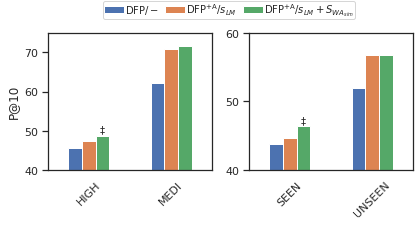

In [19]:
import matplotlib.ticker as ticker
from matplotlib import rcParams
rcParams['font.family'] = 'times'
rcParams['font.size'] = 16
import math
import seaborn as sns 
sns.set(style="white") #_theme
sns.color_palette("husl", 8)


fig, axes = plt.subplots(1,2, figsize=(6,3))

for i, k in enumerate(["freq", 'bvocab']):
    ax = axes[i]
    dfs_mean = dfs_means[k]
    
    dfs_mean['xtick'] = dfs_mean.index
    
    ylim=(40, 75) if k == 'freq' else (40, 60)
    markers = ['','','',  '', u"$\u2021$", ''] if k=='freq' else ['','','',  '', u"$\u2021$", '']
    
    df1 = dfs_mean.query(f"dataset == 'pureLM'")[['xtick','p10_def_sap', 'dataset']].rename(columns={"p10_def_sap": "p10"})
    df1['model'] = ''
    df2 = dfs_mean.query(f"dataset == 'pureLM'")[['xtick','p10_def_dap', 'dataset']].rename(columns={"p10_def_dap": "p10"})
    df2['model'] = 'LMAnchor'
    df3 = dfs_mean.query(f"dataset == 'AddSWOWSimilar'")[['xtick','p10_def_dap', 'dataset']].rename(columns={"p10_def_dap": "p10"})
    df3['model'] = 'LMSWOWAnchor'
    df_res = pd.concat([df1, df2, df3], axis=0)
    ax = pd.pivot(df_res.sort_values('model', ascending=False), index='xtick', values='p10', columns='model').plot(kind = 'bar',
                                                                                                                   ylim=ylim, 
                                                                                                                   ax=ax
                                                                                                                  )
    #                                                                                                                    figsize=(5,4), 
    if i==0:
        ax.set_ylabel('P@10')
    ax.set(xlabel=None)
    # plt.legend(loc=(1.01,0.5))
    ax.get_legend().remove()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.set_xticklabels(['HIGH', 'MEDI'] if k=="freq" else ["SEEN", "UNSEEN"], rotation = 45)
    ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='major',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=True,
            left=True #if dataset=='DIAG' else False
        ) # labels
    
    if i==0:
        labels=[r'$\mathregular{DFP}/-$', r'$\mathregular{DFP^{+A}}/s_{LM}$', r'$\mathregular{DFP^{+A}}/s_{LM}+ S_{WA_{sim}}$']
        fig.legend(labels, ncol=len(labels), loc= 'center',bbox_to_anchor=(0.53, 1),
                   fontsize='small', borderaxespad=-0.1,
                   labelspacing=0.5, columnspacing=0.6,
                   handletextpad=0.1,
                   borderpad=0.1,
                  ) 

    
    for i, bar in enumerate(ax.patches):
        print(i, bar.get_height(), markers[i] )
        if markers[i]=="": continue 
        ax.annotate(markers[i],
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()*0.99), ha='center', va='center',
                       size=10, 
                       xytext=(0, 8),
                       textcoords='offset points')
    

plt.tight_layout()
plt.savefig('../log/barplot_with_swow_sim_anchors_freq_vocab.pdf',  bbox_inches='tight')
plt.show()